In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets
import seaborn as sb
plt.rcParams['figure.figsize'] = (5.0, 5.0)

In [2]:
# Load diabetes dataset
data = datasets.load_diabetes()
print(data.DESCR) # Description

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [18]:
# Functions to speed up analysis

# Single Regression
def SingleRegression(x, y):
    print('Single Linear Regression')
    
    # Build model
    model = LinearRegression().fit(x, y)

    # Get predicted y values
    yhat = model.intercept_ + (model.coef_[0] * x)
    
    # Get R Squared
    r2 = r2_score(y, yhat)
    
    # Get mean squared error
    mse = mean_squared_error(y, yhat)
    
    # Print Summary
    print("Equation: y = {} + {} * xi".format(model.intercept_[0], model.coef_[0][0]))
    print("R Squared: {}%".format(r2 * 100))
    print("Mean Squared Error: {}".format(mse))
    
    # Get stats
    X = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    # Plot
    plt.scatter(x, y, color='blue', label='Samples')
    plt.plot(x, yhat, color='red', label='Line of Regression')
    plt.legend()
    plt.show()
    
# Prepare and run data on a single field from our independent variables
def RunTests(field):
    X = x[field].values.reshape(-1, 1)

    SingleRegression(X, y)
    sb.histplot(X)
    
# Run VIF tests on a set of independent variables
def vifs(ivars):
    
    # Get the score for each independent variable
    vifs = [vif(X.values, i) for i in range(len(X.columns))]
    
    # Print our results & check for our general rules
    print("VIF Scores:")
    vif_total = 0
    exceeds_10 = False
    for col, val in zip(X.columns, vifs):
        
        # Sum the vif scores
        vif_total += val
        
        # Check if any values are greater than 10
        if val > 10:
            exceeds_10 = True
            
        # Print the score
        print("{} = {}".format(col, val))
        
    # Print our general rules
    print("VIF Mean: {}".format(vif_total / len(vifs)))
    if exceeds_10:
        print("There is at least 1 value that is greater than 10")
    else:
        print("No values are greater than 10")
    
# Run a Multiple Regression test
def MultipleRegressions(x, y):
    
    # Build model
    model = LinearRegression().fit(x, y)
        
    # Print a summary from statsmodels
    X = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    print(results.summary())


In [4]:
"""

First we need to check which independent variables are worth keeping in our dataset.

So first let's create a dataframe and make it easy to extract our data and start
creating models.

"""

# Organize our data
x = data.data
y = data.target.reshape(-1, 1)

x = pd.DataFrame(x, columns=['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'])
x.head()

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Single Linear Regression
Equation: y = 152.13348416289594 + 69.71535567841465 * xi
R Squared: 0.18543357106460823%
Mean Squared Error: 5918.888899586022
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8174
Date:                Wed, 07 Oct 2020   Prob (F-statistic):              0.366
Time:                        09:24:21   Log-Likelihood:                -2546.8
No. Observations:                 442   AIC:                             5098.
Df Residuals:                     440   BIC:                             5106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

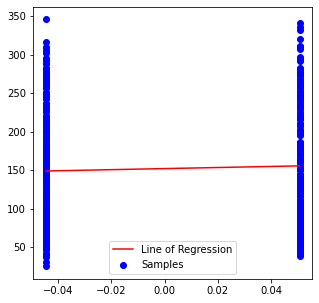

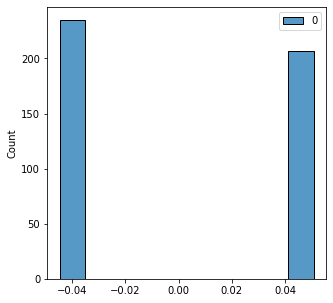

In [5]:
"""

After looking at all our independent variables, we can say confidently that
all of them have a significant correlation with our dependent variable except
sex, which is laid out here. The p > 0.05 meaning that there is probably no
real world correlation between sex and heart disease. So we're going to exclude
this variable.

"""

RunTests('sex')

In [6]:
# Remove sex from independent variables
del x['sex']

In [13]:
"""

When we check for multicollinearity, tc and ldl seem to be the most problematic.
Fire let's remove tc, and see what that does to our multicollinearity.

"""

# Check for multicollinearity
vifs(x)

VIF Scores:
const = 0.9999999999999998
age = 1.2047195466353064
bmi = 1.4729024291856778
bp = 1.4064317966319035
ldl = 2.9257570632456793
hdl = 3.615897578663044
tch = 7.782854667938324
ltg = 2.1469757762034343
glu = 1.4764880119336896
VIF Mean: 2.559114096715229
No values are greater than 10


In [9]:
# Lets start by removing just tc, and see what happens
del x['tc']

In [14]:
"""

This seems a lot more reasonable. Remember that this is the general
rule when it comes to VIF scores.

VIF General Rule:
    1. If the mean of the VIF values is above 5, you have multicollinearity.
    2. If any VIF values exceed 10, that variable is causing multicollinearity.

So now we should be good to run a multiple regression with these independent
variables.

"""

# Rerun vif scores
vifs(x)

VIF Scores:
const = 0.9999999999999998
age = 1.2047195466353064
bmi = 1.4729024291856778
bp = 1.4064317966319035
ldl = 2.9257570632456793
hdl = 3.615897578663044
tch = 7.782854667938324
ltg = 2.1469757762034343
glu = 1.4764880119336896
VIF Mean: 2.559114096715229
No values are greater than 10


In [20]:
"""

It looks like we can only explain a little less than 50% of our variance,
and that some of these independent variables don't make a whole lot of sense.

For example, the coefficient for 'age' is negative. However, we know that 
risk of disease tends to get worse as you get older. Also, it's p value
is no longer significant.

Also, ldl, hdl, tch, and glu no longer seem to be significant.

Let's first throw out age, because it's probably reasonable to assume that
age can be correlated with many of these measures.

"""

# Run Multiple Regressions on our remaining independent variables
MultipleRegressions(x, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     53.54
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           4.68e-60
Time:                        09:47:33   Log-Likelihood:                -2395.2
No. Observations:                 442   AIC:                             4808.
Df Residuals:                     433   BIC:                             4845.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.624     57.982      0.0

In [21]:
# Remove age
del x['age']

In [23]:
"""

It looks like all that did was reduced the difference between the R Squared
and the R Squared adjusted by 0.001

That isn't that great of an improvement. So let's throw out tch next because
it is the least significant variable still in our model

"""

# Re run the multiple regression
MultipleRegressions(x, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     61.26
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           6.53e-61
Time:                        09:49:49   Log-Likelihood:                -2395.3
No. Observations:                 442   AIC:                             4807.
Df Residuals:                     434   BIC:                             4839.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.622     58.031      0.0

In [24]:
# Remove tch
del x['tch']

In [26]:
"""

Another tiny improvement between the R Squared and the R Squared Adjusted.

Glu seems to be the last variable that is still not significant, so let's
take that out as well.

"""

# Re run the multiple regression
MultipleRegressions(x, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     71.62
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           7.54e-62
Time:                        09:50:56   Log-Likelihood:                -2395.3
No. Observations:                 442   AIC:                             4805.
Df Residuals:                     435   BIC:                             4833.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.619     58.095      0.0

In [27]:
# Remove glu
del x['glu']

In [29]:
"""

We're still only making micro adjustments in our R Squared and R Squared
Adjusted.

Just for the sake of exploration, let's remove ldl because it isn't "as significant"
as our other variables, although it is still significant.

"""

# Re run the multiple regression
MultipleRegressions(x, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     85.94
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           9.91e-63
Time:                        09:55:05   Log-Likelihood:                -2395.6
No. Observations:                 442   AIC:                             4803.
Df Residuals:                     436   BIC:                             4828.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.617     58.128      0.0

In [30]:
# Remove ldl
del x['ldl']

In [32]:
"""

And nowe we're starting to see a dip in our explained variance, so our best
model is probably the previous regression we ran, if we're only using 
multiple linear regression.

"""


# Re run the multiple regression
MultipleRegressions(x, y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     105.6
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           7.24e-63
Time:                        09:56:21   Log-Likelihood:                -2397.7
No. Observations:                 442   AIC:                             4805.
Df Residuals:                     437   BIC:                             4826.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.627     57.916      0.0